## Defining Helping functions for U-net architecture


### Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Cropping3D
from tensorflow.keras.layers import UpSampling3D

### Convolution block :-

In [70]:
def conv_block(input,num_filters):
  x = Conv3D(num_filters,3,activation = 'relu')(input)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)

  x = Conv3D(num_filters,3,activation = 'relu')(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)
  return x


Encoder block :-

In [71]:
def encoder_block(input,num_filters):
  x = conv_block(input,num_filters)
  p = MaxPooling3D(pool_size=(2,2,2))(x)

  return x, p

 Decoder block :-

In [72]:
def decoder_block(input,skip_features,num_filters):
  x = UpSampling3D(size = 1)(input)
  x = Conv3DTranspose(num_filters,2,strides=2)(x)
  skip_features = Cropping3D(((4,4), (4,4), (4,4)))(skip_features)
  x = tf.concat([skip_features,x], axis = 4)
  x = conv_block(x,num_filters)

  '''x = UpSampling3D(size = 1)(b1)
  print(x)
  x = Conv3DTranspose(num_filters,2,strides=2)(x)
  
  skip_features = Cropping3D(((4,4), (4,4), (4,4)))(s[3])
  x = tf.concat([skip_features,x], axis = 4)
  x = conv_block(x,num_filters) 
  num_filters = num_filters/2
  print(num_filters)'''

  return x


In [74]:

def unet(input_shape,filter_no,no_of_downsamples):
  inputs = Input(input_shape)
  # encoder part
  s=[]#skip 
  p=[]#passed
  a,b = encoder_block(inputs,filter_no)
  s.append(a)
  p.append(b)
  for i in range(no_of_downsamples-1):
    filter_no *= 2
    a,b = encoder_block(p[i],filter_no)
    s.append(a)
    p.append(b)

  # Bridge Part
  b1 = conv_block(p[no_of_downsamples-1],filter_no * 2)

  # Decoder part
  #d = []
  #Decoder1
  num_filters = filter_no
  x = UpSampling3D(size = 1)(b1)
  x = Conv3DTranspose(num_filters,2,strides=2)(x)
  print(x)
  skip_features = Cropping3D(((4,4), (4,4), (4,4)))(s[3])
  x = tf.concat([skip_features,x], axis = 4)
  x = conv_block(x,num_filters) 
  num_filters = num_filters/2
  print(x)
  #Decoder2
  x = UpSampling3D(size = 1)(x)
  print(x)
  x = Conv3DTranspose(num_filters,2,strides=2)(x)
  print(x)
  skip_features = Cropping3D(((16,16), (16,16), (16,16)))(s[2])
  print(x)
  x = tf.concat([skip_features,x], axis = 4)
  x = conv_block(x,num_filters) 
  num_filters = num_filters/2
  #Decoder1
  x = UpSampling3D(size = 1)(x)
  x = Conv3DTranspose(num_filters,2,strides=2)(x)
  print(x)
  skip_features = Cropping3D(((40,40), (40,40), (40,40)))(s[1])
  x = tf.concat([skip_features,x], axis = 4)
  x = conv_block(x,num_filters) 
  num_filters = num_filters/2
  #Decoder1
  x = UpSampling3D(size = 1)(x)
  x = Conv3DTranspose(num_filters,2,strides=2)(x)
  skip_features = Cropping3D(((88,88), (88,88), (88,88)))(s[0])
  x = tf.concat([skip_features,x], axis = 4)
  x = conv_block(x,num_filters) 
  num_filters = num_filters/2
  outputs = Conv3D(1,1,activation="sigmoid")(x) #(d[no_of_downsamples-1])
  model = tf.keras.Model(inputs = inputs, outputs = outputs)
  return model
    


In [75]:
model = unet((572,572,572,3), 64, 4 )

KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 56, 512), dtype=tf.float32, name=None), name='conv3d_transpose_52/BiasAdd:0', description="created by layer 'conv3d_transpose_52'")
KerasTensor(type_spec=TensorSpec(shape=(None, 52, 52, 52, 512), dtype=tf.float32, name=None), name='conv3d_327/Relu:0', description="created by layer 'conv3d_327'")
KerasTensor(type_spec=TensorSpec(shape=(None, 52, 52, 52, 512), dtype=tf.float32, name=None), name='up_sampling3d_52/concat_2:0', description="created by layer 'up_sampling3d_52'")
KerasTensor(type_spec=TensorSpec(shape=(None, 104, 104, 104, 256), dtype=tf.float32, name=None), name='conv3d_transpose_53/BiasAdd:0', description="created by layer 'conv3d_transpose_53'")
KerasTensor(type_spec=TensorSpec(shape=(None, 104, 104, 104, 256), dtype=tf.float32, name=None), name='conv3d_transpose_53/BiasAdd:0', description="created by layer 'conv3d_transpose_53'")
KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 200, 128), dtype=tf.float32, name=

In [76]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 572, 572, 5  0           []                               
                                72, 3)]                                                           
                                                                                                  
 conv3d_316 (Conv3D)            (None, 570, 570, 57  5248        ['input_27[0][0]']               
                                0, 64)                                                            
                                                                                                  
 conv3d_317 (Conv3D)            (None, 568, 568, 56  110656      ['conv3d_316[0][0]']             
                                8, 64)                                                      

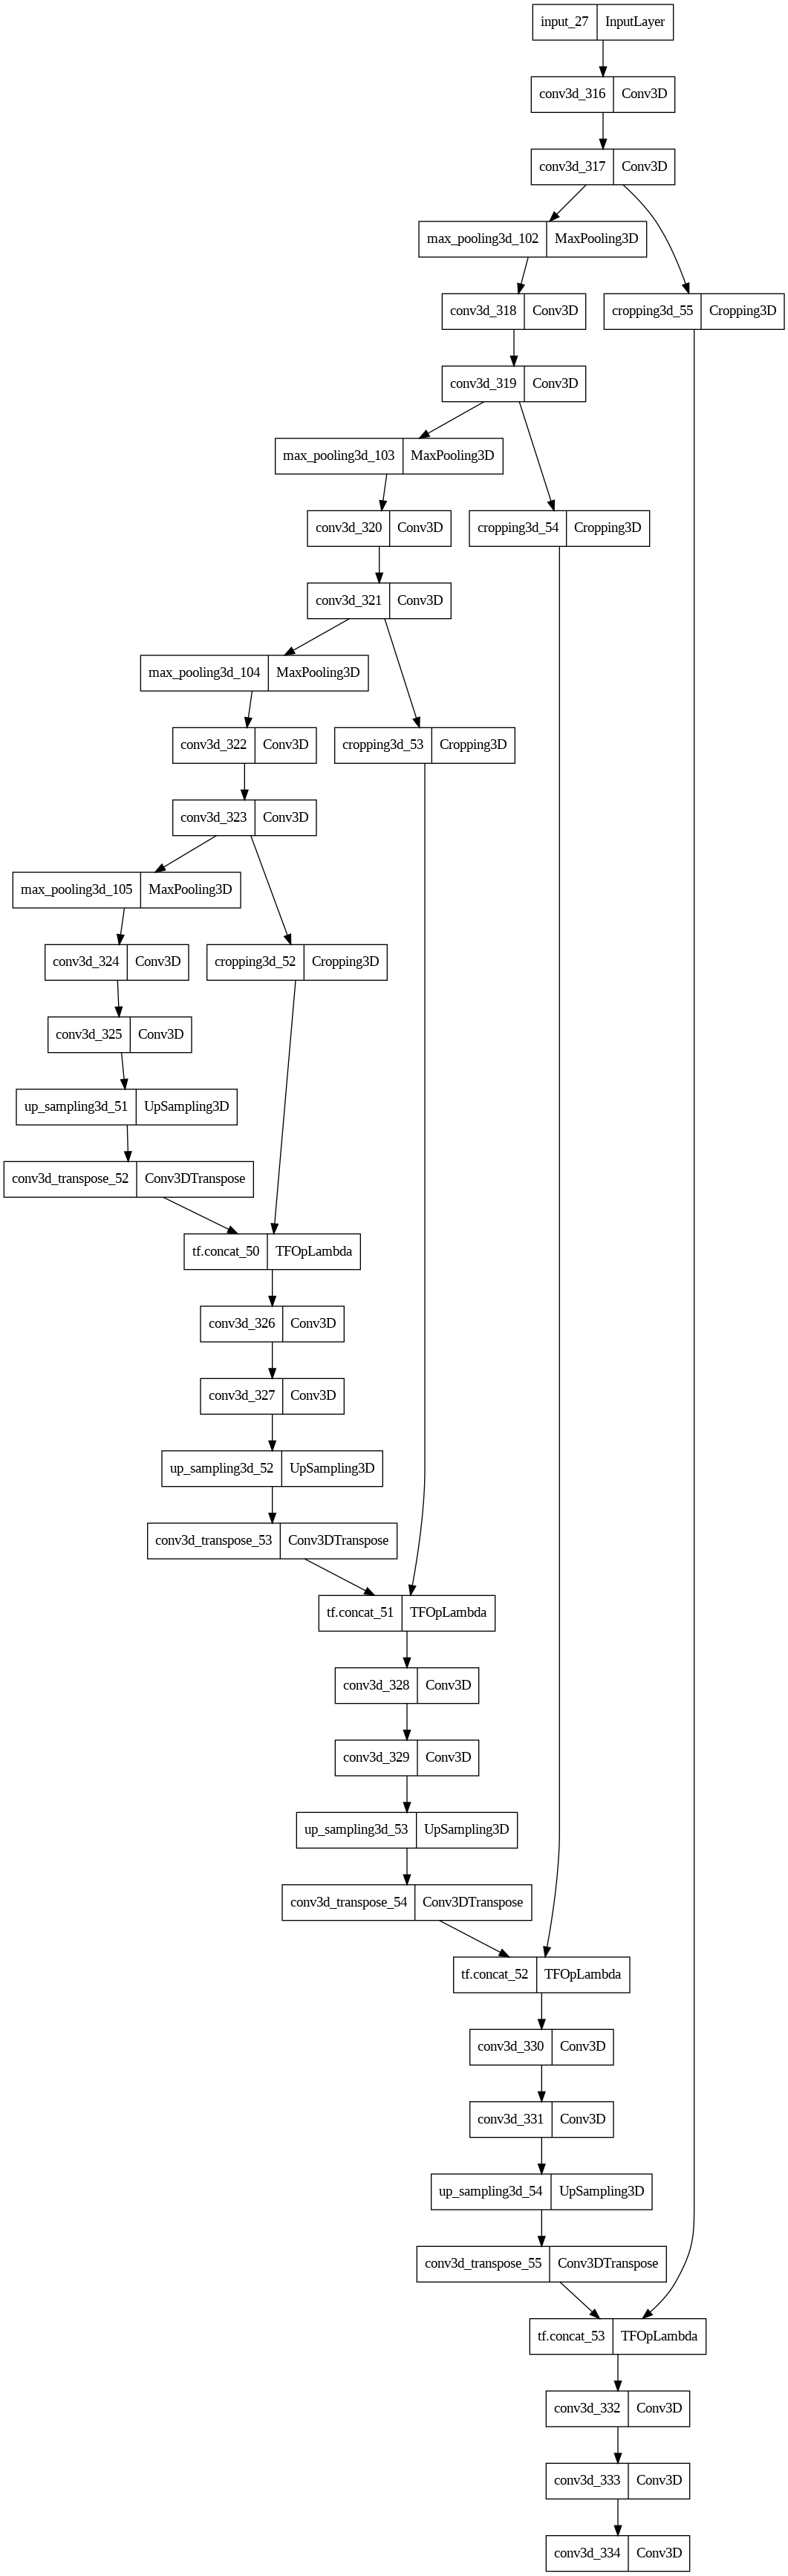

In [77]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)